In [1]:
# %%

import sys
sys.path.append('./code')
sys.path.append('./data')


import gillespy2
import numpy as np
import matplotlib.pyplot as plt
from MISA import *
from clustering import *

from sklearn.cluster import KMeans

# from https://github.com/eepperly/Randomly-Pivoted-Cholesky
from rpcholesky import rpcholesky 
from matrix import KernelMatrix


import sklearn 
from scipy.linalg import lstsq as scipy_lstsq

import cmcrameri.cm as cmc


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.25

np.random.seed(1)


2024-05-26 23:12:25,388 - GillesPy2 - WARNING - Unable to use C++ optimized solvers due to one or more missing dependencies: ['g++']. The performance of this package can be significantly increased if you install/configure these on your machine.


In [2]:
param0=0.01
param1=0.1
param2=1.0

In [3]:

nSims=50
Tmax=100.0
nT=int(100)

trajs0 = np.zeros([nSims,nT,2])
trajs1 = np.zeros([nSims,nT,2])
trajs2 = np.zeros([nSims,nT,2])


for i in range(0,nSims):
    model0 = create_MISA_model_numpy(end_time=Tmax,nSamples=int(nT),frval=param0,astart=np.random.randint(0,numpy.round(100.0)),bstart=np.random.randint(0,numpy.round(100.0)))

    model1 = create_MISA_model_numpy(end_time=Tmax,nSamples=int(nT),frval=param1,astart=np.random.randint(0,numpy.round(100.0)),bstart=np.random.randint(0,numpy.round(100.0)))

    model2 = create_MISA_model_numpy(end_time=Tmax,nSamples=int(nT),frval=param2,astart=np.random.randint(0,numpy.round(100.0)),bstart=np.random.randint(0,numpy.round(100.0)))

    ssa_solver0 = gillespy2.NumPySSASolver(model=model0)
    ssa_solver1 = gillespy2.NumPySSASolver(model=model1)
    ssa_solver2 = gillespy2.NumPySSASolver(model=model2)

    results0= model0.run(solver=ssa_solver0)
        
    trajs0[i,:,0] = results0['a'][0:nT]
    trajs0[i,:,1] = results0['b'][0:nT]   


    results= model1.run(solver=ssa_solver1)
        
    trajs1[i,:,0] = results['a'][0:nT]
    trajs1[i,:,1] = results['b'][0:nT]

    results2= model2.run(solver=ssa_solver2)

    trajs2[i,range(0,nT),0] = results2['a'][0:nT]
    trajs2[i,range(0,nT),1] = results2['b'][0:nT]       

In [4]:
traj0_concat = np.concatenate(trajs0,axis=0)
traj1_concat = np.concatenate(trajs1,axis=0)
traj2_concat = np.concatenate(trajs2,axis=0)
traj_concat = np.vstack((traj0_concat,traj1_concat,traj2_concat))

In [5]:
bandwidth=50
v_min =5
nCholesky=100
nGrid = 100
nClust = 4

testx = np.meshgrid(np.linspace(0,125,nGrid),np.linspace(0,125,nGrid),indexing='ij')

testx=np.vstack(map(np.ravel, testx))

C:\Users\Chris\AppData\Local\Temp\ipykernel_20428\2716476690.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  testx=np.vstack(map(np.ravel, testx))


In [6]:
# repeat Markov state clustering for each  3 scenarios

K = KernelMatrix(traj_concat,bandwidth=bandwidth)
lra = rpcholesky(K,nCholesky)
F = lra.get_right_factor()
idx = lra.get_indices()
    
# dense eigensolver
normal = F.T @ (F @ np.ones(F.shape[1]))
normal[normal > 0] = normal[normal > 0]**-.5
F = F * normal[np.newaxis, :]
vals, vecs = np.linalg.svd(F, full_matrices=False)[1:3]
vecs = vecs.T * normal[:, np.newaxis]

V = vecs[:, 0:v_min]
KK = np.zeros(np.shape(K))
KK[:,:]=K[:,:] # very slow step but I don't know how to extract a numpy matrix from abstract Kernelmatrix

aaT = scipy_lstsq(KK,V,check_finite=False, lapack_driver='gelsy')[0]
#np.linalg.pinv(KK) @ (V)

dtest= sklearn.metrics.pairwise.pairwise_distances(X=traj_concat, Y=testx.T, metric='euclidean', n_jobs=1)
ktest = np.exp(-0.5*dtest**2/bandwidth**2)
testf = aaT.T @ ktest

kmeans = KMeans(n_clusters=nClust).fit(V)
predict = kmeans.predict(testf.T)


c:\Users\Chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
reshaped_discrete_traj = np.reshape(kmeans.labels_,[3,nSims,nT])

#reshaped_discrete_traj0 = np.reshape(kmeans0.labels_,[nSims,nT])
#reshaped_discrete_traj1 = np.reshape(kmeans1.labels_,[nSims,nT])
#reshaped_discrete_traj2 = np.reshape(kmeans2.labels_,[nSims,nT])

In [8]:
colors = np.array(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'])

C:\Users\Chris\AppData\Local\Temp\ipykernel_20428\3255174619.py:51: RuntimeWarning: divide by zero encountered in log
  axs[0,1].pcolormesh(X0, Y0, np.log(hist0.T),cmap=cmap)
C:\Users\Chris\AppData\Local\Temp\ipykernel_20428\3255174619.py:59: RuntimeWarning: divide by zero encountered in log
  axs[1,1].pcolormesh(X1, Y1, np.log(hist1.T),cmap=cmap)
C:\Users\Chris\AppData\Local\Temp\ipykernel_20428\3255174619.py:66: RuntimeWarning: divide by zero encountered in log
  axs[2,1].pcolormesh(X2, Y2, np.log(hist2.T),cmap=cmap )


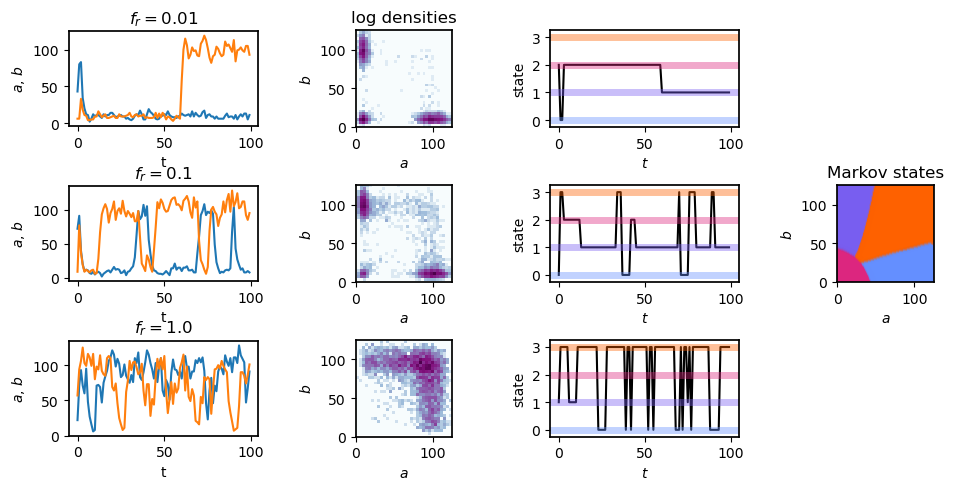

In [9]:
# %%
#fig, axs = plt.subplots(3, 4, figsize=(10,5), gridspec_kw={'width_ratios': [1.5, 1, 1.5,1.3]},layout='constrained')
fig, axs = plt.subplots(3, 4, figsize=(10,5),layout='tight')

traj_plot0 = 30
traj_plot1=0
traj_plot2=5

axs[0,0].plot(trajs0[traj_plot0,:,0])
axs[0,0].plot(trajs0[traj_plot0,:,1])
axs[0,0].set_box_aspect(0.5)
axs[0,0].set_xlabel('t')
axs[0,0].set_ylabel('$a$, $b$')
axs[0,0].set_title('$f_r=0.01$')
axs[0,1].set_title('log densities')


axs[1,0].plot(trajs1[traj_plot1,:,0])
axs[1,0].plot(trajs1[traj_plot1,:,1])
axs[1,0].set_box_aspect(0.5)
axs[1,0].set_xlabel('t')
axs[1,0].set_ylabel('$a$, $b$')
axs[1,0].set_title('$f_r=0.1$')


axs[2,0].plot(trajs2[traj_plot2,:,0])
axs[2,0].plot(trajs2[traj_plot2,:,1])
axs[2,0].set_box_aspect(0.5)
axs[2,0].set_xlabel('t')
axs[2,0].set_ylabel('$a$, $b$')
axs[2,0].set_title('$f_r=1.0$')


hist0, xedges0, yedges0 = np.histogram2d(traj0_concat[:,0], traj0_concat[:,1], bins=35)
hist1, xedges1, yedges1 = np.histogram2d(traj1_concat[:,0], traj1_concat[:,1], bins=35)
hist2, xedges2, yedges2 = np.histogram2d(traj2_concat[:,0], traj2_concat[:,1], bins=35)

X0, Y0 = np.meshgrid(xedges0, yedges0)
X1, Y1 = np.meshgrid(xedges1, yedges1)
X2, Y2 = np.meshgrid(xedges2, yedges2)


cmap = plt.get_cmap('BuPu')
#cmap = plt.get_cmap('plasma')

#cmap = cmc.navia_r

cmap.set_bad(cmap(0))  # Set NaN color to the lowest color in the colormap


axs[0,1].pcolormesh(X0, Y0, np.log(hist0.T),cmap=cmap)
axs[0,1].set_xlim([0,125])
axs[0,1].set_ylim([0,125])
axs[0,1].set_box_aspect(1)
axs[0,1].set_xlabel('$a$')
axs[0,1].set_ylabel('$b$')


axs[1,1].pcolormesh(X1, Y1, np.log(hist1.T),cmap=cmap)
axs[1,1].set_xlim([0,125])
axs[1,1].set_ylim([0,125])
axs[1,1].set_box_aspect(1)
axs[1,1].set_xlabel('$a$')
axs[1,1].set_ylabel('$b$')

axs[2,1].pcolormesh(X2, Y2, np.log(hist2.T),cmap=cmap )
axs[2,1].set_xlim([0,125])
axs[2,1].set_ylim([0,125])
axs[2,1].set_box_aspect(1)
axs[2,1].set_xlabel('$a$')
axs[2,1].set_ylabel('$b$')




axs[0,2].plot(reshaped_discrete_traj[0,traj_plot0,:],color='k')#'#009E73')
axs[1,2].plot(reshaped_discrete_traj[1,traj_plot1,:],color='k')#'#009E73')
axs[2,2].plot(reshaped_discrete_traj[2,traj_plot2,:],color='k')#'#009E73')

axs[0,2].hlines([0,1,2,3],xmin=-10,xmax=125,colors=colors[0:4],linewidth=5,alpha=0.4)
axs[1,2].hlines([0,1,2,3],xmin=-10,xmax=125,colors=colors[0:4],linewidth=5,alpha=0.4)
axs[2,2].hlines([0,1,2,3],xmin=-10,xmax=125,colors=colors[0:4],linewidth=5,alpha=0.4)


axs[0,2].set_xlim([-5,105])
axs[1,2].set_xlim([-5,105])
axs[2,2].set_xlim([-5,105])


axs[0,2].set_ylim([-0.25,3.25])
axs[0,2].set_yticks([0,1,2,3])
axs[1,2].set_ylim([-0.25,3.25])
axs[1,2].set_yticks([0,1,2,3])
axs[2,2].set_ylim([-0.25,3.25])
axs[2,2].set_yticks([0,1,2,3])

axs[0,2].set_xlabel('$t$')
axs[0,2].set_ylabel('state')
axs[1,2].set_xlabel('$t$')
axs[1,2].set_ylabel('state')
axs[2,2].set_xlabel('$t$')
axs[2,2].set_ylabel('state')


axs[1,3].scatter(testx[0,:],testx[1,:],s=25,c = colors[predict],alpha=0.5,edgecolors='none')
axs[1,3].set_xlim([0,125])
axs[1,3].set_ylim([0,125])
axs[1,3].set_box_aspect(1)
axs[1,3].set_xlabel('$a$')
axs[1,3].set_ylabel('$b$')
axs[1,3].set_title('Markov states')

fig.delaxes(axs[0,3])
fig.delaxes(axs[2,3])

plt.tight_layout()

fig.savefig('figs\gene_examples.pdf', format="pdf")